### Organize Import and Dependencies

In [1]:
import requests
import pandas as pd
from urllib.parse import quote_plus
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Ingestion:

#### Define Ticker List

In [2]:
# Define Companies and Tickers of Interest:
# ticker_lst = ('AA', 'PINS', 'DAL', 'UAL', 'META', 'SNAP', 'RDDT', 'BA', 'LMT', 'RTX', 'CMG', 'SG')
ticker_lst = ('AA', 'PINS', 'DAL', 'UAL', 'META', 'SNAP', 'RDDT', 'BA', 'LMT', 'RTX', 'CMG', 'SG', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'V', 'MA', 'PYPL', 'ADBE', 'CRM', 'ORCL', 'INTC', 'AMD', 'AVGO', 'QCOM', 'IBM', 'CSCO', 'NFLX', 'DIS', 'TMUS', 'VZ', 'T', 'HD', 'LOW', 'COST', 'WMT', 'TGT', 'MCD', 'SBUX', 'PEP', 'KO', 'NKE', 'LULU', 'TJX', 'MAR', 'ABNB', 'UBER', 'DE', 'CAT', 'GE', 'HON', 'MMM', 'F', 'GM', 'NOC', 'GD', 'UNH', 'PFE', 'MRK', 'JNJ', 'LLY', 'ABBV', 'TMO', 'DHR', 'CVX', 'XOM', 'COP', 'SLB', 'EOG', 'NEE', 'DUK', 'SO', 'PLD', 'AMT', 'SPG', 'O', 'EQIX', 'SHOP', 'SQ', 'AFRM', 'INTU', 'ADP', 'NOW', 'PANW', 'CRWD', 'ZS', 'OKTA', 'TEAM', 'WDAY', 'ZM', 'UPS')

#### Create Reusable DoltHub Query

In [3]:
def dolthub_query(owner: str, repo: str, branch: str, query: str) -> pd.DataFrame:
    """
    Execute SQL against a DoltHub repo and return a Pandas DataFrame.
    
    Parameters
    ----------
    owner : str
        DoltHub repository owner (e.g., "post-no-preference")
    repo : str
        Repository name (e.g., "earnings")
    branch : str
        Branch name (normally "master" if unchanged)
    query : str
        SQL query to execute (raw SQL)
    
    Returns
    -------
    pd.DataFrame
        Result rows returned by the query
    """

    encoded = quote_plus(query)
    url = f"https://www.dolthub.com/api/v1alpha1/{owner}/{repo}/{branch}?q={encoded}"

    resp = requests.get(url)
    resp.raise_for_status()

    json_data = resp.json()

    # Convert to df if rows exist
    if "rows" in json_data and json_data["rows"]:
        return pd.DataFrame(json_data["rows"])
    else:
        return pd.DataFrame()   # Return empty df instead of failing

#### Query Income Statement:

#### Query Earnings Per Share Data

### EPS Consensus Metadata

### Read In Data From CSVs - Statically Saved

In [4]:
# Income Statement Data
df_income = pd.read_csv('income_statement_full.csv')

# Earnings per Share Data (i.e. estimate and actuals)
df_eps = pd.read_csv('eps_data_full.csv')

# Add Beat EPS Logic:
df_eps['reported'] = df_eps['reported'].astype(float)
df_eps['estimate'] = df_eps['estimate'].astype(float)
df_eps['miss'] = np.where(df_eps['reported'] < df_eps['estimate'], 1, 0)

# Analyst EPS prediction metadata (i.e. number estimates, high, low)
df_eps_metadata = pd.read_csv('eps_metadata.csv')

In [5]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266 entries, 0 to 2265
Data columns (total 23 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   act_symbol                                                 2266 non-null   object 
 1   date                                                       2266 non-null   object 
 2   period                                                     2266 non-null   object 
 3   sales                                                      2266 non-null   int64  
 4   cost_of_goods                                              2266 non-null   int64  
 5   gross_profit                                               2266 non-null   int64  
 6   selling_administrative_depreciation_amortization_expenses  2266 non-null   int64  
 7   income_after_depreciation_and_amortization                 2266 non-null   int64  
 8   non_oper

In [6]:
df_eps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   act_symbol       1505 non-null   object 
 1   period_end_date  1505 non-null   object 
 2   reported         1501 non-null   float64
 3   estimate         1501 non-null   float64
 4   miss             1505 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 58.9+ KB


In [7]:
df_eps_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1000 non-null   object 
 1   act_symbol       1000 non-null   object 
 2   period           1000 non-null   object 
 3   period_end_date  1000 non-null   object 
 4   consensus        963 non-null    float64
 5   recent           806 non-null    float64
 6   count            963 non-null    float64
 7   high             963 non-null    float64
 8   low              963 non-null    float64
 9   year_ago         989 non-null    float64
dtypes: float64(6), object(4)
memory usage: 78.3+ KB


### Prepare Earnings Data:

In [8]:
# Filter for Quarter Periods
df_income = df_income[df_income['period'] == 'Quarter']

# Create a date future column to join on
df_income['date_1a'] = df_income['date'].apply(lambda row : str(int(row[:4]) + 1) + row[4:])

# Create 2 year lagged date
df_income['date_2a'] = df_income['date'].apply(lambda row : str(int(row[:4]) + 2) + row[4:])

# Create Merged DataFrames
# Merge to first Dataframe - 1 year growth
df_income_merge_1 = pd.merge(df_income, df_income, left_on = ['act_symbol', 'date'], right_on = ['act_symbol', 'date_1a'], suffixes = ('_current', '_1yl'))

# Merge to second DataFrame - 2 year growth
df_income_merge_2 = pd.merge(df_income_merge_1, df_income, left_on = ['act_symbol', 'date_current'], right_on = ['act_symbol', 'date_2a'], suffixes = ('_2yl', ''))

# Create Growth columns + DataFrame
growth_cols = []
for col in df_income.columns:
    if col not in ['act_symbol', 'date', 'date_1a', 'date_2a', 'period']:
        growth_col_1 = col + '_1yg'
        growth_col_2 = col + '_2yg'
        df_income_merge_2[growth_col_1] = df_income_merge_2[col + '_current'] / df_income_merge_2[col + '_1yl']
        df_income_merge_2[growth_col_2] = df_income_merge_2[col + '_current'] / df_income_merge_2[col]
        growth_cols.append(growth_col_1)
        growth_cols.append(growth_col_2)

# Retain Specified Growth Columns
df_is_growth = df_income_merge_2[['act_symbol', 'date_current'] + growth_cols]

# Change date_current to datetime type
df_is_growth['date_current'] = pd.to_datetime(df_is_growth['date_current'])

C:\Users\jshuc\AppData\Local\Temp\ipykernel_26864\1993524909.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_is_growth['date_current'] = pd.to_datetime(df_is_growth['date_current'])


### Prepare EPS Beat History Data

In [9]:
# Use datetime data type and sort values by ticker, end date
df_eps['period_end_date'] = pd.to_datetime(df_eps['period_end_date'])
df_eps = df_eps.sort_values(['act_symbol', 'period_end_date'])

# Create 4-quarter lag columns grouped by ticker
df_eps['miss_lag1'] = df_eps.groupby('act_symbol')['miss'].shift(1)
df_eps['miss_lag2'] = df_eps.groupby('act_symbol')['miss'].shift(2)
df_eps['miss_lag3'] = df_eps.groupby('act_symbol')['miss'].shift(3)
df_eps['miss_lag4'] = df_eps.groupby('act_symbol')['miss'].shift(4)

# Final dataframe with current + 4 lag beats
df_beat_history = df_eps[
    [
        'act_symbol',
        'period_end_date',
        'miss',
        'miss_lag1',
        'miss_lag2',
        'miss_lag3',
        'miss_lag4'
    ]
]

df_beat_history

,act_symbol,period_end_date,miss,miss_lag1,miss_lag2,miss_lag3,miss_lag4
0,AA,2022-03-31,0,NaN,NaN,NaN,NaN
1,AA,2022-06-30,0,0.0,NaN,NaN,NaN
2,AA,2022-09-30,1,0.0,0.0,NaN,NaN
3,AA,2022-12-31,0,1.0,0.0,0.0,NaN
4,AA,2023-03-31,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
1500,ZS,2024-10-31,0,0.0,0.0,0.0,0.0
1501,ZS,2025-01-31,0,0.0,0.0,0.0,0.0
1502,ZS,2025-04-30,0,0.0,0.0,0.0,0.0
1503,ZS,2025-07-31,0,0.0,0.0,0.0,0.0


In [10]:
#### Combine Data Together
df_combined = pd.merge(df_is_growth, df_beat_history, left_on = ['act_symbol', 'date_current'], right_on = ['act_symbol', 'period_end_date'])

# Filter for Lag 4 Not NA:
df_combined = df_combined[df_combined['miss_lag4'].notna()]

# Add COGS growth of O where applicable (financial firms that do not have COGS)
df_combined['cost_of_goods_1yg'] = df_combined['cost_of_goods_1yg'].fillna(0)
df_combined['cost_of_goods_2yg'] = df_combined['cost_of_goods_2yg'].fillna(0)

# Add non_operating_income growth of O where applicable (financial firms that do not have non_operating_income)
df_combined['non_operating_income_1yg'] = df_combined['non_operating_income_1yg'].fillna(0)
df_combined['non_operating_income_2yg'] = df_combined['non_operating_income_2yg'].fillna(0)

# Add interest_expense growth of O where applicable (financial firms that did not have interest expense)
df_combined['interest_expense_1yg'] = df_combined['interest_expense_1yg'].fillna(0)
df_combined['interest_expense_2yg'] = df_combined['interest_expense_2yg'].fillna(0)

## Binary Classifiers:

#### Create Data Pipeline Transformations

In [11]:
from sklearn.preprocessing import FunctionTransformer

# Function to handle replacement of infinite values
import numpy as np
from sklearn.preprocessing import FunctionTransformer

def replace_inf_with_percentile(X):
    """
    X: 2D numpy array
    Replace +inf with 99th percentile and -inf with 1st percentile per column.
    """
    X = np.asarray(X, dtype=float).copy()

    # Copy for percentile calc, but treat inf as NaN
    X_no_inf = X.copy()
    X_no_inf[np.isinf(X_no_inf)] = np.nan

    # Per-column 1st and 99th percentiles (ignore NaNs)
    p01 = np.nanpercentile(X_no_inf, 1, axis=0)
    p99 = np.nanpercentile(X_no_inf, 99, axis=0)

    # Replace +inf with 99th percentile
    pos_inf_mask = (X == np.inf)
    if pos_inf_mask.any():
        X[pos_inf_mask] = p99[np.where(pos_inf_mask)[1]]

    # Replace -inf with 1st percentile
    neg_inf_mask = (X == -np.inf)
    if neg_inf_mask.any():
        X[neg_inf_mask] = p01[np.where(neg_inf_mask)[1]]

    return X

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Remove sparsely populated and unimportant columns and Create 
remove_columns = ['date_current', 'period_end_date', 'minority_interest_1yg', 'minority_interest_2yg', 'investment_gains_1yg', 'investment_gains_2yg', 'other_income_1yg', 'other_income_2yg', 'extras_and_discontinued_operations_1yg', 'extras_and_discontinued_operations_2yg', 'income_before_depreciation_and_amortization_1yg', 'income_before_depreciation_and_amortization_2yg', 'depreciation_and_amortization_1yg', 'depreciation_and_amortization_2yg']

# Create X and Y DataFrames
X = df_combined[[col for col in df_combined.columns if col not in remove_columns + ['miss']]]
y = df_combined['miss']

# Define Numerical Columns
numerical_columns = [col for col in X.columns if col not in ['act_symbol', 'date_current']]

# Define Categorical Columns
categorical_columns = []

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_pipeline = Pipeline([
    ("inf_clip", FunctionTransformer(replace_inf_with_percentile,
                                    feature_names_out="one-to-one")),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Create Categorical Pipeline - drop first and output non-sparse matrix
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop = 'first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numerical_columns),
        ("cat", categorical_pipeline, categorical_columns),
    ],
    remainder="drop"
)

#### Fit Pipeline to Data

In [13]:
# Fit and transform on X_train data
X_train_transformed = preprocessor.fit_transform(X_train)

# Get numerical feature names
num_features = preprocessor.named_transformers_['num'].get_feature_names_out()

# Get categorical feature names
# cat_features = preprocessor.named_transformers_['cat'] \
#     .named_steps['onehot'].get_feature_names_out(categorical_columns)

# Combine and convert to DataFrame
all_features = np.concatenate([num_features]) #, cat_features])

X_train_tr = pd.DataFrame(
    X_train_transformed,
    columns=all_features,
    index=X_train.index
)

# Get X_test_tr as dataframe
X_test_transformed = preprocessor.transform(X_test)

X_test_tr = pd.DataFrame(
    X_test_transformed,
    columns=all_features,
    index=X_test.index
)

### Logistic Lasso Regression with 5 Fold Cross Validation

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import pandas as pd

# --------------------------------------
# Hyperparameter grids
# --------------------------------------
# C is inverse of regularization strength (1/alpha)
C_grid = np.logspace(-4, 4, 20)        # similar span to alpha_grid
l1_ratio_grid = np.linspace(0, 1, 11)  # 0.0, 0.1, ..., 1.0

param_grid = {
    "C": C_grid,
    "l1_ratio": l1_ratio_grid
}

# --------------------------------------
# Model
# --------------------------------------
log_reg = LogisticRegression(
    penalty="elasticnet",
    solver="saga",        # required for elastic-net
    max_iter=50000,
    n_jobs=-1,
    class_weight="balanced"
)

# --------------------------------------
# Grid Search
# --------------------------------------
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# --------------------------------------
# Fit (no log-transform, binary y only)
# --------------------------------------
grid.fit(X_train_tr, y_train)

# --------------------------------------
# Results
# --------------------------------------
print("Best parameters:", grid.best_params_)
print("Best CV Precision:", grid.best_score_)

cv_results = pd.DataFrame(grid.cv_results_)
cv_results.head()

Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Best parameters: {'C': np.float64(0.012742749857031334), 'l1_ratio': np.float64(0.8)}
Best CV Precision: 0.35372212560004024


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.311537,0.163435,0.032707,0.015285,0.0001,0.0,"{'C': 0.0001, 'l1_ratio': 0.0}",0.424242,0.349206,0.313725,0.285714,0.305085,0.335595,0.048869,46
1,0.059830,0.021365,0.005799,0.001767,0.0001,0.1,"{'C': 0.0001, 'l1_ratio': 0.1}",0.196891,0.000000,0.000000,0.000000,0.000000,0.039378,0.078756,208
2,0.067421,0.015685,0.004616,0.001071,0.0001,0.2,"{'C': 0.0001, 'l1_ratio': 0.2}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
3,0.057089,0.011930,0.009006,0.008911,0.0001,0.3,"{'C': 0.0001, 'l1_ratio': 0.30000000000000004}",0.000000,0.000000,0.188482,0.188482,0.000000,0.075393,0.092337,203
4,0.052604,0.005440,0.005773,0.000915,0.0001,0.4,"{'C': 0.0001, 'l1_ratio': 0.4}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217


#### Classification Report and Analysis - Lasso Logistic Regression

In [15]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

# Predicted class labels
y_pred = grid.predict(X_test_tr)

# Predicted probabilities for positive class
y_proba = grid.predict_proba(X_test_tr)[:, 1]

print("=== PERFORMANCE METRICS (OUT-OF-SAMPLE) ===")
print(f"Accuracy:            {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision:           {precision_score(y_test, y_pred):.3f}")
print(f"Recall:              {recall_score(y_test, y_pred):.3f}")
print(f"F1 score:            {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC:             {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC (Avg-Prec):   {average_precision_score(y_test, y_proba):.3f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

=== PERFORMANCE METRICS (OUT-OF-SAMPLE) ===
Accuracy:            0.765
Precision:           0.298
Recall:              0.438
F1 score:            0.354
ROC-AUC:             0.635
PR-AUC (Avg-Prec):   0.272

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       185
           1       0.30      0.44      0.35        32

    accuracy                           0.76       217
   macro avg       0.60      0.63      0.61       217
weighted avg       0.81      0.76      0.78       217



#### Model Update Notes:
- Originally wanted to predict if stocks beat earnings.
- Realized that this happens much more frequently, (~80%) of the time.
- Model predicting almost all beats.
- Needed to flip to logic, and predict misses not beates
- This does not include Balance Sheet, Ratios, or Transcript Data

##### Beat Predictions:
```
=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.12      0.03      0.05        36
           1       0.83      0.96      0.89       181

    accuracy                           0.81       217
   macro avg       0.48      0.49      0.47       217
weighted avg       0.72      0.81      0.75       217
```

##### Miss Predictions:
```
=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       185
           1       0.30      0.44      0.35        32

    accuracy                           0.76       217
   macro avg       0.60      0.63      0.61       217
weighted avg       0.81      0.76      0.78       217
```

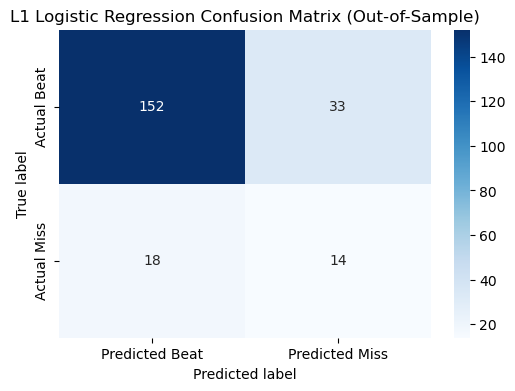

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Beat", "Predicted Miss"],
    yticklabels=["Actual Beat", "Actual Miss"]
)
plt.title("L1 Logistic Regression Confusion Matrix (Out-of-Sample)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

#### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import pandas as pd

# --------------------------------------
# Hyperparameter grid (simple + effective)
# --------------------------------------
rf_param_grid = {
    "n_estimators": [200, 500, 800],        # trees
    "max_depth": [None, 5, 10, 20],         # limits overfitting
    "min_samples_split": [2, 5, 10],        # tree regularization
    "min_samples_leaf": [1, 2, 5],          # tree regularization
    "max_features": ["sqrt", "log2"]        # feature sampling
}

# --------------------------------------
# Model
# --------------------------------------
rf_model = RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",   # <<< same purpose as before
    random_state=42
)

# --------------------------------------
# Grid Search
# --------------------------------------
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring="f1",        # <<< same target metric as before
    cv=5,
    n_jobs=-1,
    verbose=1
)

# --------------------------------------
# Fit
# --------------------------------------
rf_grid.fit(X_train_tr, y_train)

# --------------------------------------
# Results
# --------------------------------------
print("Best parameters:", rf_grid.best_params_)
print("Best CV F1:", rf_grid.best_score_)

rf_cv_results = pd.DataFrame(rf_grid.cv_results_)
rf_cv_results.head()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 800}
Best CV F1: 0.2625618681776408


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.618503,0.111393,0.576832,0.162557,None,sqrt,1,2,200,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.0,0.190476,0.0,0.0,0.0,0.038095,0.076190,213
1,2.741627,0.369062,0.493552,0.176702,None,sqrt,1,2,500,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.0,0.285714,0.0,0.0,0.0,0.057143,0.114286,201
2,4.154638,0.266953,0.575465,0.144325,None,sqrt,1,2,800,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.0,0.285714,0.0,0.0,0.0,0.057143,0.114286,201
3,1.460465,0.355839,0.450078,0.180850,None,sqrt,1,5,200,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.1,0.181818,0.0,0.0,0.0,0.056364,0.073720,209
4,2.061317,0.314340,0.333150,0.097300,None,sqrt,1,5,500,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.1,0.260870,0.0,0.0,0.0,0.072174,0.101988,189


In [18]:
# Predicted class labels
y_pred = rf_grid.predict(X_test_tr)

# Predicted probabilities for positive class
y_proba = rf_grid.predict_proba(X_test_tr)[:, 1]

print("=== PERFORMANCE METRICS (OUT-OF-SAMPLE) ===")
print(f"Accuracy:            {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision:           {precision_score(y_test, y_pred):.3f}")
print(f"Recall:              {recall_score(y_test, y_pred):.3f}")
print(f"F1 score:            {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC:             {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC (Avg-Prec):   {average_precision_score(y_test, y_proba):.3f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

=== PERFORMANCE METRICS (OUT-OF-SAMPLE) ===
Accuracy:            0.811
Precision:           0.333
Recall:              0.281
F1 score:            0.305
ROC-AUC:             0.746
PR-AUC (Avg-Prec):   0.334

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       185
           1       0.33      0.28      0.31        32

    accuracy                           0.81       217
   macro avg       0.61      0.59      0.60       217
weighted avg       0.80      0.81      0.80       217



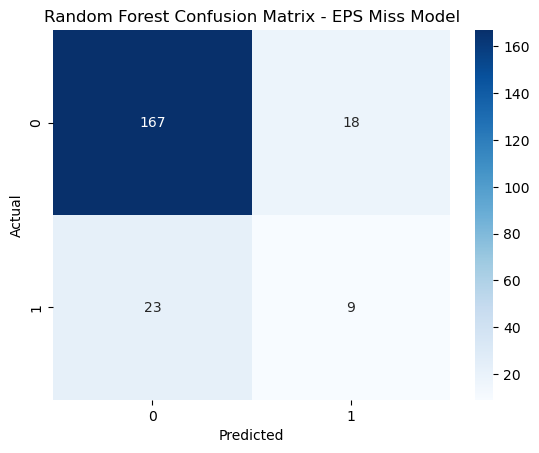

In [19]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix - EPS Miss Model")
plt.show()

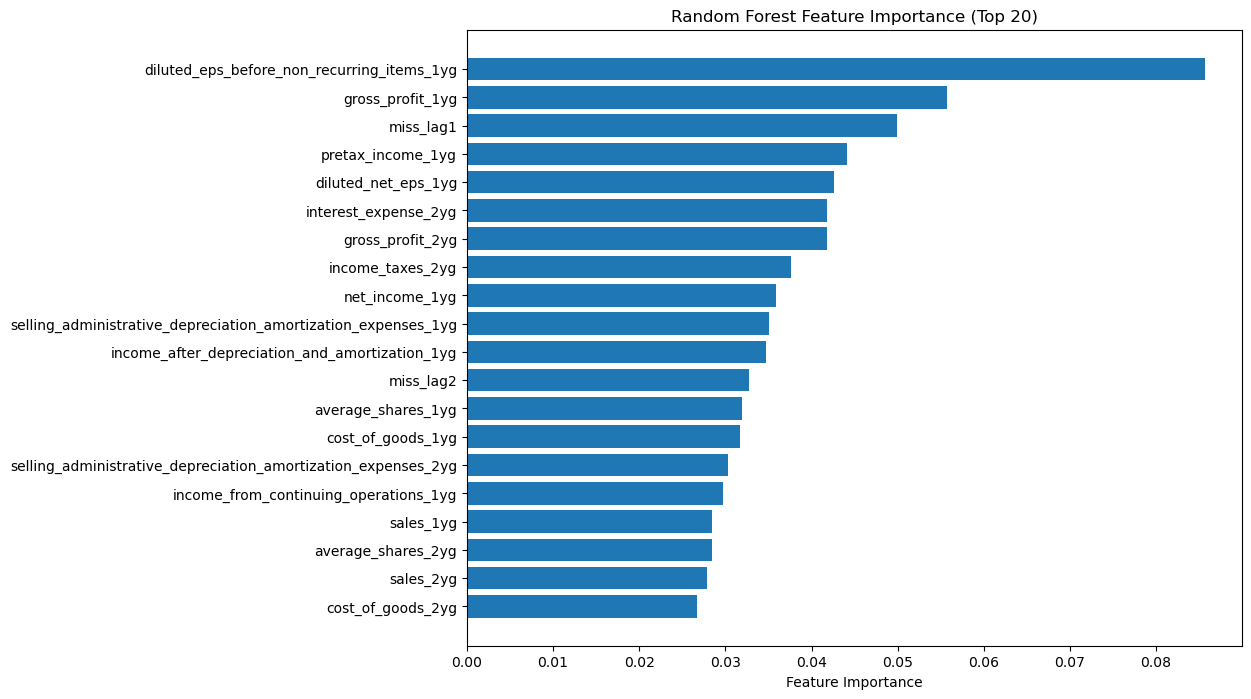

In [20]:
# Best model after GridSearchCV
rf_best = rf_grid.best_estimator_

# Extract importances
importances = rf_best.feature_importances_
feature_names = X_train_tr.columns

# Create DataFrame
rf_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

top_n = 20
top_features = rf_importance_df.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"], top_features["importance"])
plt.gca().invert_yaxis()  # largest at top
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Top 20)")
plt.show()

#### XGBoost

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# --------------------------------------
# Hyperparameter grid (simple + effective)
# --------------------------------------
xgb_param_grid = {
    "n_estimators": [200, 500, 800],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.5]
}

# --------------------------------------
# Model
# --------------------------------------
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    
    # *****************************
    # KEY SETTING FOR IMBALANCE
    # *****************************
    scale_pos_weight = (y_train.value_counts()[0] / 
                        y_train.value_counts()[1]),
    
    random_state=42,
)

# --------------------------------------
# Grid Search
# --------------------------------------
xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring="f1",       # <<< optimize miss class F1
    cv=5,
    n_jobs=-1,
    verbose=1
)

# --------------------------------------
# Fit
# --------------------------------------
xgb_grid.fit(X_train_tr, y_train)

# --------------------------------------
# Results
# --------------------------------------
print("Best parameters:", xgb_grid.best_params_)
print("Best CV F1:", xgb_grid.best_score_)

xgb_cv_results = pd.DataFrame(xgb_grid.cv_results_)
xgb_cv_results.head()

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Predicted class labels
y_pred = xgb_grid.predict(X_test_tr)

# Predicted probabilities for positive class
y_proba = xgb_grid.predict_proba(X_test_tr)[:, 1]

print("=== PERFORMANCE METRICS (OUT-OF-SAMPLE) ===")
print(f"Accuracy:            {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision:           {precision_score(y_test, y_pred):.3f}")
print(f"Recall:              {recall_score(y_test, y_pred):.3f}")
print(f"F1 score:            {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC:             {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC (Avg-Prec):   {average_precision_score(y_test, y_proba):.3f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix - EPS Miss Model")
plt.show()

In [ ]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb_grid.best_estimator_, max_num_features=20)
plt.title("XGBoost Feature Importance (Top 20)")
plt.show()

#### Random Forest - Optuna

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

# -------------------------------------------
# Objective: maximize F1 for miss = 1
# -------------------------------------------
def objective(trial):

    # --------------------------------------
    # Parameter search space (similar to your grid)
    # --------------------------------------
    n_estimators = trial.suggest_int("n_estimators", 200, 800)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # --------------------------------------
    # Model
    # --------------------------------------
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )

    # --------------------------------------
    # CV F1 scoring
    # --------------------------------------
    f1 = cross_val_score(
        model,
        X_train_tr,
        y_train,
        cv=5,
        scoring="f1"  # <<< minority class F1 optimized
    ).mean()

    return f1


# -------------------------------------------
# Run Study (Bayesian search)
# -------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# -------------------------------------------
# Best results
# -------------------------------------------
print("Best F1:", study.best_value)
print("Best params:", study.best_params)

#### Train Best Model Using Optuna Parameters

In [ ]:
best_params = study.best_params

rf_opt = RandomForestClassifier(
    **best_params,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_opt.fit(X_train_tr, y_train)

In [ ]:
# Predicted class labels
y_pred = rf_opt.predict(X_test_tr)

# Predicted probabilities for positive class
y_proba = rf_opt.predict_proba(X_test_tr)[:, 1]

print("=== PERFORMANCE METRICS (OUT-OF-SAMPLE) ===")
print(f"Accuracy:            {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision:           {precision_score(y_test, y_pred):.3f}")
print(f"Recall:              {recall_score(y_test, y_pred):.3f}")
print(f"F1 score:            {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC:             {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC (Avg-Prec):   {average_precision_score(y_test, y_proba):.3f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Optuna Confusion Matrix - EPS Miss Model")
plt.show()

In [ ]:
# Make sure date is a datetime
eps["period_end_date"] = pd.to_datetime(eps["period_end_date"])

# -----------------------------
# Earnings surprise & beat/miss
# -----------------------------
# Surprise = reported EPS - consensus estimate
eps["eps_surprise"] = eps["reported"] - eps["estimate"]

# Beat/miss indicator:
#   1  = beat
#   -1 = miss
#   0  = exactly in line
eps["beat_miss"] = np.where(
    eps["eps_surprise"] > 0, 1,
    np.where(eps["eps_surprise"] < 0, -1, 0)
)

# -----------------------------
# Wide matrix: date x ticker
# -----------------------------
# Use beat/miss indicator for correlation
beat_wide = eps.pivot_table(
    index="period_end_date",
    columns="act_symbol",
    values="beat_miss"
)

# Drop dates where *all* tickers are NaN
beat_wide = beat_wide.dropna(how="all")

# -----------------------------
# Correlation matrix
# -----------------------------
beat_corr = beat_wide.corr()

# Peek at the top-left corner
beat_corr.iloc[:10, :10]

surprise_wide = eps.pivot_table(
    index="period_end_date",
    columns="act_symbol",
    values="eps_surprise"
).dropna(how="all")

surprise_corr = surprise_wide.corr()
surprise_corr.iloc[:10, :10]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(beat_corr, cmap="coolwarm", center=0)
plt.title("Correlation of EPS Beat/Miss Across Firms")
plt.tight_layout()
plt.show()